# Improving a Model's Performance

This one will be using the same dataset as `A301.ipynb`, but we are going to take some steps to address the high bias present in the model.

First, we'll import take the same steps to prepare the model, importing the same libraries, dataset, and splitting the dataset according to a 60-20-20 split.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

Reading, seperating the target from the features, and splitting the data goes just as before.

In [3]:
data = pd.read_csv("dccc_prepared.csv")
x = data.iloc[:,:-1]
y = data["default payment next month"]
x_shuffle = x.sample(frac=1,random_state=0)
y_shuffle = y.sample(frac=1, random_state=0)
x_new, x_test_2, y_new, y_test_2 = train_test_split(
    x_shuffle, y_shuffle, test_size=0.2, random_state=0)
dev_per = x_test_2.shape[0]/x_new.shape[0]
x_train_2, x_dev_2, y_train_2, y_dev_2 = train_test_split(
    x_new, y_new, test_size=dev_per, random_state=0)
print(x_train_2.shape, y_train_2.shape)
print(x_dev_2.shape, y_dev_2.shape)
print(x_test_2.shape, y_test_2.shape)
x_dev = torch.tensor(x_dev_2.values).float()
y_dev = torch.tensor(y_dev_2.values)
x_test = torch.tensor(x_test_2.values).float()
y_test = torch.tensor(y_test_2.values)

(28036, 22) (28036,)
(9346, 22) (9346,)
(9346, 22) (9346,)


Considering that the model is suffering from high bias, the focus should be on raising the number of epochs or increasing the size of the network by adding additional layers or units to each layer. I am going to try a little of both, increasing the layers by 1 and also increasing the number of epochs.

In [4]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.linear1 = nn.Linear(input_size, 10)
        self.linear2 = nn.Linear(10, 10)
        self.linear3 = nn.Linear(10, 10)
        self.linear4 = nn.Linear(10,10)
        self.linear5 = nn.Linear(10, 2)
    def forward(self, x):
        z = F.relu(self.linear1(x))
        z = F.relu(self.linear2(z))
        z = F.relu(self.linear3(z))
        z = F.relu(self.linear4(z))
        o = F.log_softmax(self.linear5(z), dim=1)
        return o

In [5]:
model = Classifier(x_train_2.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
batch_size = 128

In [6]:
train_losses, dev_losses, train_acc, dev_acc = [], [], [], []
for e in range(epochs):
    x_, y_ = shuffle(x_train_2, y_train_2)
    running_loss = 0
    running_acc = 0
    iterations = 0
    for i in range(0, len(x_), batch_size):
        iterations += 1
        b = i + batch_size
        x_batch = torch.tensor(x_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ps = torch.exp(pred)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
    dev_loss = 0
    acc = 0
    with torch.no_grad():
        pred_dev = model(x_dev)
        dev_loss = criterion(pred_dev, y_dev)
        ps_dev = torch.exp(pred_dev)
        top_p, top_class_dev = ps_dev.topk(1,dim=1)
        acc = accuracy_score(y_dev, top_class_dev)
    train_losses.append(running_loss/iterations)
    dev_losses.append(dev_loss)
    train_acc.append(running_acc/iterations)
    dev_acc.append(acc)
    print(
        "Epoch: {}/{}.. ".format(e+1, epochs), 
        "Training Loss: {:.3f}..".format(running_loss/iterations),
        "Validation Loss: {:.3f}..".format(dev_loss),
        "Training Accuracy: {:.3f}..".format(running_acc/iterations),
        "Validation Accuracy: {:.3f}..".format(acc))
        

Epoch: 1/100..  Training Loss: 0.671.. Validation Loss: 0.615.. Training Accuracy: 0.587.. Validation Accuracy: 0.651..
Epoch: 2/100..  Training Loss: 0.606.. Validation Loss: 0.598.. Training Accuracy: 0.675.. Validation Accuracy: 0.686..
Epoch: 3/100..  Training Loss: 0.596.. Validation Loss: 0.592.. Training Accuracy: 0.689.. Validation Accuracy: 0.691..
Epoch: 4/100..  Training Loss: 0.595.. Validation Loss: 0.590.. Training Accuracy: 0.689.. Validation Accuracy: 0.693..
Epoch: 5/100..  Training Loss: 0.591.. Validation Loss: 0.588.. Training Accuracy: 0.692.. Validation Accuracy: 0.692..
Epoch: 6/100..  Training Loss: 0.590.. Validation Loss: 0.587.. Training Accuracy: 0.691.. Validation Accuracy: 0.693..
Epoch: 7/100..  Training Loss: 0.590.. Validation Loss: 0.582.. Training Accuracy: 0.690.. Validation Accuracy: 0.695..
Epoch: 8/100..  Training Loss: 0.584.. Validation Loss: 0.583.. Training Accuracy: 0.693.. Validation Accuracy: 0.699..
Epoch: 9/100..  Training Loss: 0.583.. V

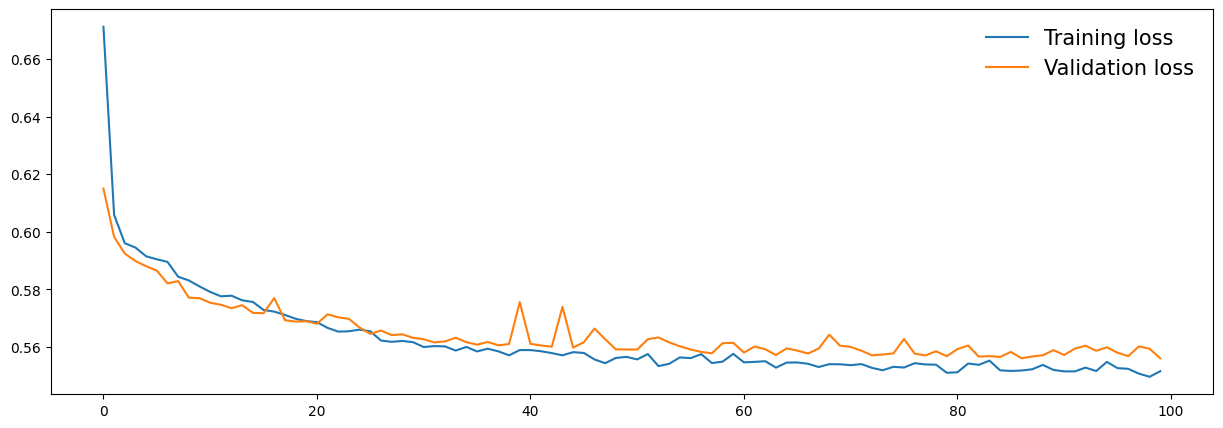

In [7]:
fig = plt.figure(figsize=(15,5))
plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Validation loss')
plt.legend(frameon=False, fontsize=15)
plt.show()

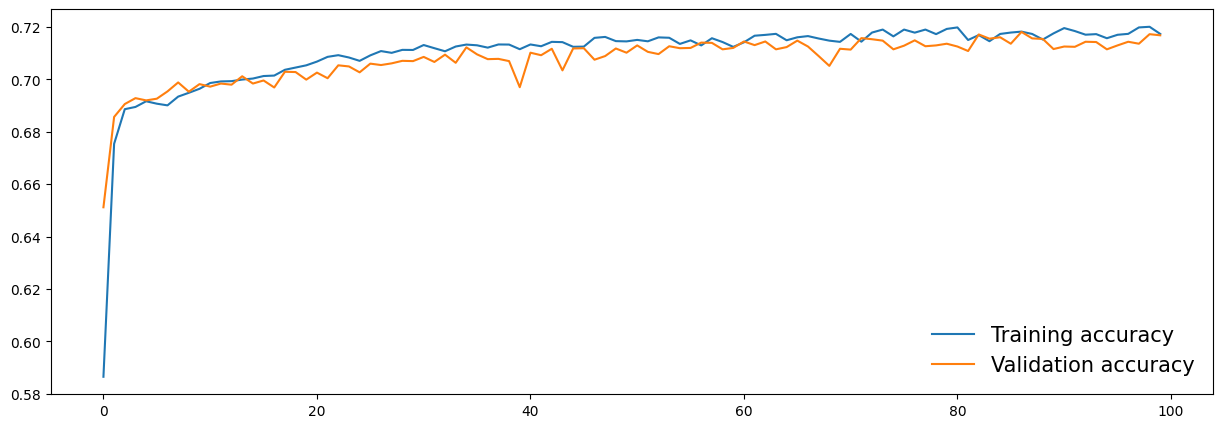

In [8]:
fig = plt.figure(figsize=(15,5))
plt.plot(train_acc, label='Training accuracy')
plt.plot(dev_acc, label='Validation accuracy')
plt.legend(frameon=False, fontsize=15)
plt.show()

Hmmmm.... I need to learn more about this. At this point I am just going through the motions of the exercise without true understanding. Maybe there are some fundamentals I am missing?

In [12]:
# here we are going to store a checkpoint of the current state of this model for use in A303.ipynb

checkpoint = {"input": x_train_2.shape[1], "state_dict": model.state_dict()}

In [13]:
# save the model
torch.save(checkpoint, "final_model_checkpoint.pth")